<a href="https://colab.research.google.com/github/semilem/Financial-Models-Numerical-Methods/blob/master/ContinuousVectorOperationData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from scipy.signal import hilbert, butter, filtfilt, periodogram
from scipy.fft import fft, fftfreq,fftshift , ifft
import time
from scipy.stats import sem

from numba import jit

In [ ]:
rng = np.random.default_rng()
rng.normal(size = 100)


array([-1.49675025,  1.05789658,  2.26875814,  0.72334659, -0.4993797 ,
       -2.44281295,  0.78175763,  0.10234392, -0.02582129, -0.08214802,
        2.08776631,  0.70736928,  0.94898291,  1.5240717 ,  0.73589238,
       -1.055268  ,  1.58890654, -0.44807176,  0.52976245, -0.75959285,
       -0.1043912 ,  1.29545564, -0.20361571, -1.58302389, -0.78338034,
        0.93262569,  0.09887249,  1.04249001,  0.07088412,  0.05631158,
       -0.61535874,  0.16556766, -1.24422003, -0.14523266, -1.05254747,
       -0.66157252, -1.75443724, -1.18225216,  0.75808141, -1.47007556,
        1.08399631, -0.35208371,  1.11558471,  0.54120728,  0.0800823 ,
        2.37213984, -1.10346391,  1.46855584, -0.28571561,  0.07544457,
       -0.6134313 ,  0.14713999,  1.2001822 , -0.58041172,  0.70505481,
        0.69041479,  1.19229233,  0.05340648,  1.37443384,  0.17165947,
        1.78213411,  0.07067196, -1.52686783, -1.05704411,  0.220731  ,
        0.28669879,  0.52595889, -0.70284483, -1.96432972, -0.50

0.02 is time simulated,
from time 0 to 0.0199998 s
observe Rb decay for 0.00030000000000000003 s, with 0.0005 time constant decay
Thus amplitude decays by exp(-0.6000000000000001) = 0.5488116360940264,
0.49393047248462374
And the pump constant Tp of A = A0(1-exp(-t_pump/Tp) is 6.167114444336624e-05 s


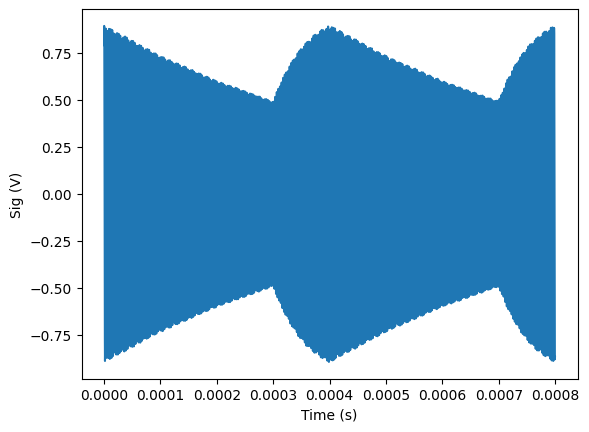

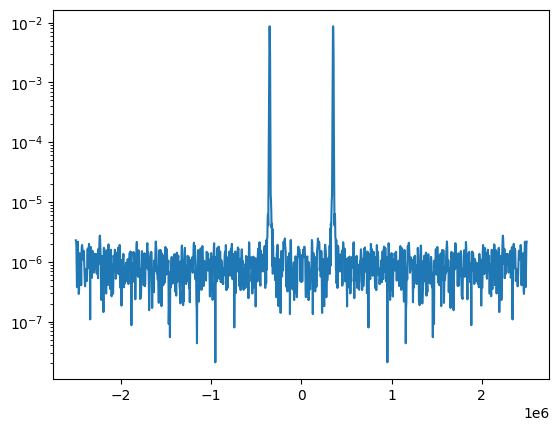

In [ ]:
fr = 2500 #Repetition rate Hz
fs = 5e6  #Digitizer rate Hz
rng = np.random.default_rng()
gRb = 2*np.pi*7e9 #Hz/T Rb gyromagnetic ratio
Bz = 50e-6 #T Bias field
rho = 1000e-9  # V/rtHz #Voltage noise
noise_power = (rho)**2 * fs / 2  #T^2/Hz
shots = 50  #Number of shots to generate
t_pump = 100e-6 #s Pump time
pts_pump = int( t_pump*fs)
t_tot = shots/fr
pts_per_rep = int(fs/fr)
print(f"{t_tot} is time simulated,")
pts_tot = int(fs*t_tot)
t = np.linspace(0, t_tot - 1/fs, int(fs*t_tot))
print(f"from time 0 to {max(t)} s")
wm = 2*np.pi*(2*fr) #mod frequency
Br = 5e-6 #T mod field
T2 = 0.5e-3 #s Decay time

freq = 750 #Hz
w0 = gRb*np.sqrt((Bz+wm/gRb)**2 +(Br)**2)
phi_x = np.pi/2
phi_y = np.pi/2
w_x = 2*np.pi*freq
w_y = w_x #
Bx = 0 #T
By = 0
phi = (gRb*gRb*(Bx*Br)/(w0*(wm**2-w_x**2)))*(wm*np.cos(w_x*t+phi_x)*np.sin(wm*t) - w_x*np.sin(w_x*t+phi_x)*np.cos(wm*t))
phi +=(gRb*gRb*(By*Br)/(w0*(wm**2-w_y**2)))*(-wm*np.cos(w_y*t+phi_y)*np.cos(wm*t) - w_y*np.sin(w_y*t+phi_y)*np.sin(wm*t))
bx = 0
by = 0 #T
phi += (gRb*gRb*Br/(w0*wm))*(bx*np.sin(wm*t)- by*(np.cos(wm*t)))#+np.pi/2
sig = ((w0+gRb*Bz+wm)/(2*w0))*np.sin((w0-wm)*t + phi)
sig += -((w0-gRb*Bz-wm)/(2*w0))*np.sin((w0+wm)*t + phi)
sig += rng.normal(scale=np.sqrt(noise_power), size=t.shape[0])
#w0 = gRb*Bz
#sig = np.sin(w0*t) #need to replace with signal

t_obs = 1/fr - t_pump
pts_obs = int(t_obs*fs)
A0 = 1
A1 = 0.9*A0
print(f'observe Rb decay for {t_obs} s, with {T2} time constant decay')
print(f'Thus amplitude decays by exp(-{t_obs/T2}) = {np.exp(-t_obs/T2)},')
Ad= A1*np.exp(-t_obs/T2)
print(Ad)
Tp = t_pump/(np.log((A0-Ad)/(A0-A1)))
print(f'And the pump constant Tp of A = A0(1-exp(-t_pump/Tp) is {Tp} s')
wfs = np.reshape(sig, (shots, pts_per_rep)) #[[shot1], [shot2]...]
time_pump = np.linspace(0, t_pump - 1/fs, pts_pump)
time_dec =np.linspace(0, t_obs - 1/fs, pts_obs)
tau = Tp*np.log(1-Ad/A0)
pumpFun = np.array((1-np.exp(-(time_pump-tau)/(Tp))))
decayFun = np.array(np.exp(-time_dec/T2))
wfs= np.hstack(( A1*wfs[:,pts_pump:]*decayFun, wfs[:,0:pts_pump]*pumpFun)) #[[shot1], [shot2]...]* (decay  and pump fn, element-wise mult down columns)
sig = np.ravel(wfs)
plt.plot(t[0:2*pts_per_rep], sig[0:2*pts_per_rep])
plt.ylabel('Sig (V)')
plt.xlabel('Time (s)')
plt.show()
Fsig = 2*fft(2*np.sqrt(2)*np.blackman(pts_obs)*sig[0:pts_obs])/(np.sqrt(2*fs*pts_obs))
w_2pi = fftfreq(int(pts_obs), 1/fs)

plt.semilogy(fftshift(w_2pi), fftshift(abs(Fsig)))
plt.show()

Need to make a stepwise continuous vector data function with pumping to make hilbert behave normally, to test whether my frequency domain rotation works.

Can make a simple data simulator by making a sine wave amplitude modulated like a charging and discharging capacitor with different rates.

Amplitude at the end of the decay period $t_d$ can be given by $A_d = A_1 e^{-t_d/T_2}$. Can assume a 90% initial p0larization such that $A_1=0.9A_0$, where $A_0 = 1$ can be considered max polarization.

Then, the charging equation can be described as $A(t) = A_0(1-e^{-(t - \tau)/T_p})$.

$A(0) = A_d = A_0(1-e^{\tau/T_p}) \implies \tau = T_p \ln(1-A_d/A_0)$

With $t_p$ pump time
$A(t_p) = A_1 = A_0(1-(1-A_d/A_0) )e^{-t_p/Tp} \implies T_p = t_p/(\ln(A_0 - A_d)/(A_0-A_1))$


the size of InvXTXXTPhase is (2, 1500)
the size of phases is (50, 1500)
The field gRb*np.sqrt((Bz+wm/gRb)**2 +(Br)**2) 50960.16851924847 nT
The mean of the measured w0 are 50960.24683145357+-0.09076962237147049 nT


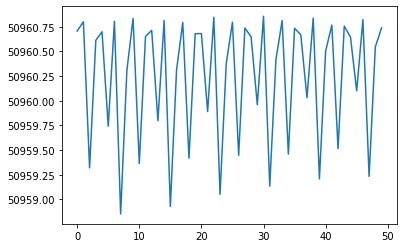

In [ ]:
analytical = hilbert(sig)
phase= np.unwrap(np.angle(analytical))

X_matPhase = np.vstack((np.ones(len(time_dec)),time_dec )).T
InvXTXXTPhase = np.linalg.inv(X_matPhase.T.dot(X_matPhase)).dot(X_matPhase.T)
print(f'the size of InvXTXXTPhase is {InvXTXXTPhase.shape}')
phases = np.reshape(phase, (shots, pts_per_rep))[:,0:pts_obs]

print(f'the size of phases is {phases.shape}')
beta = (InvXTXXTPhase@phases.T).T


wo = beta[:,1] + wm#*((w0+gRb*Bz+wm)/(2*w0))+((w0-gRb*Bz-wm)/(2*w0))*wm

plt.plot(wo/gRb*1e9)
print(f'The field gRb*np.sqrt((Bz+wm/gRb)**2 +(Br)**2) {w0/gRb*1e9} nT')
print(f'The mean of the measured w0 are {np.mean(wo)/gRb*1e9}+-{sem(wo)/gRb*1e9} nT')

In [ ]:
Sz = np.matrix([[1/2, 0], [0, -1/2]])
Iz = np.matrix([[1/2, 0], [0, -1/2]])
IzSz = np.kron(Iz, Sz)
print(IzSz)
Sx = np.matrix([[0, 1/2], [1/2, 0]])
Ix = np.matrix([[0, 1/2], [1/2, 0]])
IxSx = np.kron(Ix, Sx)
print(IxSx)
Sy = np.matrix([[0, -1j/2], [1j/2, 0]])
Iy = np.matrix([[0, -1j/2], [1j/2, 0]])
IySy = np.kron(Iy, Sy)
print(IySy)


[[ 0.25  0.    0.    0.  ]
 [ 0.   -0.25  0.   -0.  ]
 [ 0.    0.   -0.25 -0.  ]
 [ 0.   -0.   -0.    0.25]]
[[0.   0.   0.   0.25]
 [0.   0.   0.25 0.  ]
 [0.   0.25 0.   0.  ]
 [0.25 0.   0.   0.  ]]
[[ 0.  +0.j  0.  -0.j  0.  -0.j -0.25+0.j]
 [ 0.  +0.j  0.  +0.j  0.25-0.j  0.  -0.j]
 [ 0.  +0.j  0.25-0.j  0.  +0.j  0.  -0.j]
 [-0.25+0.j  0.  +0.j  0.  +0.j  0.  +0.j]]


In [ ]:
Sz = np.matrix([[1/2, 0], [0, -1/2]])
Iz = np.matrix([[1/2, 0], [0, -1/2]])
Sz_1 = np.kron(np.eye(2), Sz)
Iz_1 = np.kron(Iz, np.eye(2))
Sx_1 = np.kron(np.eye(2), Sx)
Ix_1 = np.kron(Ix, np.eye(2))
Sy_1 = np.kron(np.eye(2), Sy)
Iy_1 = np.kron(Iy, np.eye(2))
print(Iy_1*Sy_1)


[[ 0.  +0.j  0.  +0.j  0.  +0.j -0.25+0.j]
 [ 0.  +0.j  0.  +0.j  0.25+0.j  0.  +0.j]
 [ 0.  +0.j  0.25+0.j  0.  +0.j  0.  +0.j]
 [-0.25+0.j  0.  +0.j  0.  +0.j  0.  +0.j]]


Look at $I\cdot S = I_x S_x + I_y S_y +I_z S_z $

In [ ]:
IS = IxSx+IySy+IzSz
eigenvalues, eigenvectors =np.linalg.eig(IS)
print(eigenvalues)
print(eigenvectors)

[ 0.25+0.j -0.75+0.j  0.25+0.j  0.25+0.j]
[[-0.        -0.j -0.        -0.j  1.        +0.j  0.        +0.j]
 [ 0.70710678-0.j -0.70710678-0.j  0.        +0.j  0.        +0.j]
 [ 0.70710678+0.j  0.70710678+0.j  0.        +0.j  0.        +0.j]
 [-0.        -0.j -0.        -0.j  0.        +0.j  1.        +0.j]]


spin-3/2 nuclei (I) and spin-1/2 electron (Rubidium 87)
spin-5/2 nuclei (I) and spin-1/2 electron (Rubidium 85)
spin-7/2 nuclei (I) and spin-1/2 electron (Cesium)

# Rubidium 87 (3/2, 1/2)


In [ ]:
# Electron matrices
Sz = np.matrix([[1/2, 0], [0, -1/2]])
Sx = np.matrix([[0, 1/2], [1/2, 0]])
Sy = np.matrix([[0, -1j/2], [1j/2, 0]])

# Nuclei matrices (3/2 spin system)
basis = np.array([3/2, 1/2, -1/2, -3/2])  # m_I values for 3/2 nuclei

# Define step operator
def step_operator(m, I, direction='+'):
    matrix = np.zeros((4, 4), dtype=complex)  # initialize 4x4 matrix
    for i in range(4):
        for j in range(4):
            if direction == '+' and j == i + 1:  # I+ raises m_I
                matrix[i, j] = np.sqrt(I * (I + 1) - m[i] * (m[i] + 1))
            elif direction == '-' and j == i - 1:  # I- lowers m_I
                matrix[i, j] = np.sqrt(I * (I + 1) - m[i] * (m[i] - 1))
    return matrix

# Define I+ and I- operators for 3/2 nucleus
I_p = step_operator(basis, 3/2, direction='+')
I_m = step_operator(basis, 3/2, direction='-')

# Define I_x, I_y, and I_z using the step operators
I_x = 0.5 * (I_p + I_m)  # I_x = 1/2 * (I+ + I-)
I_y = 0.5j * (I_p - I_m)  # I_y = 1/2i * (I+ - I-)
I_z = np.diag([3/2, 1/2, -1/2, -3/2])  # I_z is diagonal with m_I values

# Check output the nuclei matrices
print("I_x")
print(I_x)
print("\nI_y")
print(I_y)
print("\nI_z")
print(I_z)

# Kronecker product calculations for an 8x8 basis
Sz_2 = np.kron(np.eye(4), Sz)
Iz_2 = np.kron(I_z, np.eye(2))  # Correct Iz for a 2-level system
Sx_2 = np.kron(np.eye(4), Sx)
Ix_2 = np.kron(I_x, np.eye(2))
Sy_2 = np.kron(np.eye(4), Sy)
Iy_2 = np.kron(I_y, np.eye(2))

# Print formatted matrices
def print_matrix(title, matrix):
    print(f"\n{title}\n{'-' * len(title)}")
    print(matrix)

print_matrix("IxSx", Ix_2 * Sx_2)
print_matrix("IySy", Iy_2 * Sy_2)
print_matrix("IzSz", Iz_2 * Sz_2)


I_x
[[0.       +0.j 0.       +0.j 0.       +0.j 0.       +0.j]
 [1.       +0.j 0.       +0.j 0.8660254+0.j 0.       +0.j]
 [0.       +0.j 0.8660254+0.j 0.       +0.j 1.       +0.j]
 [0.       +0.j 0.       +0.j 0.       +0.j 0.       +0.j]]

I_y
[[ 0.+0.j         0.+0.j         0.+0.j         0.+0.j       ]
 [-0.-1.j         0.+0.j         0.+0.8660254j  0.+0.j       ]
 [ 0.+0.j        -0.-0.8660254j  0.+0.j         0.+1.j       ]
 [ 0.+0.j         0.+0.j         0.+0.j         0.+0.j       ]]

I_z
[[ 1.5  0.   0.   0. ]
 [ 0.   0.5  0.   0. ]
 [ 0.   0.  -0.5  0. ]
 [ 0.   0.   0.  -1.5]]

IxSx
----
[[0.       +0.j 0.       +0.j 0.       +0.j 0.       +0.j 0.       +0.j
  0.       +0.j 0.       +0.j 0.       +0.j]
 [0.       +0.j 0.       +0.j 0.       +0.j 0.       +0.j 0.       +0.j
  0.       +0.j 0.       +0.j 0.       +0.j]
 [0.       +0.j 0.5      +0.j 0.       +0.j 0.       +0.j 0.       +0.j
  0.4330127+0.j 0.       +0.j 0.       +0.j]
 [0.5      +0.j 0.       +0.j 0.       +0

$𝐼⋅𝑆=𝐼𝑥𝑆𝑥+𝐼𝑦𝑆𝑦+𝐼𝑧𝑆𝑧$

In [ ]:
IS2 = Ix_2*Sx_2+Iy_2*Sy_2+Iz_2*Sz_2
eigenvalues, eigenvectors =np.linalg.eig(IS2)
print(eigenvalues)
print(eigenvectors)

[ 1.1160254+0.j -0.6160254+0.j -0.25     +0.j  0.75     +0.j
 -0.75     +0.j -0.25     +0.j -0.75     +0.j  0.75     +0.j]
[[-0.        -0.j -0.        -0.j  0.        +0.j  0.70710678+0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [-0.        -0.j -0.        -0.j  0.        +0.j  0.        +0.j
   1.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.70710678-0.j  0.70710678+0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [-0.        -0.j -0.        -0.j  1.        +0.j  0.70710678+0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [-0.        -0.j -0.        -0.j  0.        +0.j  0.        +0.j
   0.        +0.j  1.        +0.j  0.        +0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678-0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [-0.        -0.j -0.        -0.j  0.        +0.j  0.        +0.j
   0.        

# Rubidium 85 (5/2, 1/2)

I is nuclear spin angular momentum (5/2)

J is electron total angular momentum (1/2)

L is electron orbital angular momentum (0)

S is electron spin angular momentum (1/2)

F = I + J   (Total angular momentum of atomic state)

J = L + S    (L = 0 for S_1/2 orbital ground state)

In [ ]:
# Nuclei matrices (5/2 spin system)
basis = np.array([5/2, 3/2, 1/2, -1/2, -3/2, -5/2])  # m_I values for 5/2 nuclei

# Define step operator
def step_operator(m, I, direction='+'):
    matrix = np.zeros((6, 6), dtype=complex)  # initialize 6x6 matrix
    for i in range(6):
        for j in range(6):
            if direction == '+' and j == i + 1:  # I+ raises m_I
                matrix[i, j] = np.sqrt(I * (I + 1) - m[i] * (m[i] + 1))
            elif direction == '-' and j == i - 1:  # I- lowers m_I
                matrix[i, j] = np.sqrt(I * (I + 1) - m[i] * (m[i] - 1))
    return matrix

# Define I+ and I- operators for 5/2 nucleus
I_p = step_operator(basis, 5/2, direction='+')
I_m = step_operator(basis, 5/2, direction='-')

# Define I_x, I_y, and I_z using the step operators
I_x = 0.5 * (I_p + I_m)
I_y = 0.5j * (I_p - I_m)
I_z = np.diag([5/2, 3/2, 1/2, -1/2, -3/2, -5/2])

# Check output the nuclei matrices
print("I_x")
print(I_x)
print("\nI_y")
print(I_y)
print("\nI_z")
print(I_z)

# Kronecker product calculations for an 8x8 basis
Sz_3 = np.kron(np.eye(6), Sz)
Iz_3 = np.kron(I_z, np.eye(2))
Sx_3 = np.kron(np.eye(6), Sx)
Ix_3 = np.kron(I_x, np.eye(2))
Sy_3 = np.kron(np.eye(6), Sy)
Iy_3 = np.kron(I_y, np.eye(2))

# Print formatted matrices
def print_matrix(title, matrix):
    print(f"\n{title}\n{'-' * len(title)}")
    print(matrix)

print_matrix("IxSx", Ix_3 * Sx_3)
print_matrix("IySy", Iy_3 * Sy_3)
print_matrix("IzSz", Iz_3 * Sz_3)


I_x
[[0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j]
 [1.41421356+0.j 0.        +0.j 1.11803399+0.j 0.        +0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 1.5       +0.j 0.        +0.j 1.41421356+0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 1.41421356+0.j 0.        +0.j
  1.5       +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 1.11803399+0.j
  0.        +0.j 1.41421356+0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j]]

I_y
[[ 0.+0.j          0.+0.j          0.+0.j          0.+0.j
   0.+0.j          0.+0.j        ]
 [-0.-1.41421356j  0.+0.j          0.+1.11803399j  0.+0.j
   0.+0.j          0.+0.j        ]
 [ 0.+0.j         -0.-1.5j         0.+0.j          0.+1.41421356j
   0.+0.j          0.+0.j        ]
 [ 0.+0.j          0.+0.j         -0.-1.41421356j  0.+0.j
   0.+1.5j         0.+0.j        ]
 [ 0.+0.j          0.+0.j          0.+0.

$𝐼⋅𝑆=𝐼𝑥𝑆𝑥+𝐼𝑦𝑆𝑦+𝐼𝑧𝑆𝑧$

In [ ]:
IS3 = Ix_3*Sx_3+Iy_3*Sy_3+Iz_3*Sz_3
eigenvalues, eigenvectors =np.linalg.eig(IS3)
print(eigenvalues)
print(eigenvectors)

[ 1.66421356+0.j -1.16421356+0.j  1.63818262+0.j -1.13818262+0.j
  1.63818262+0.j -1.13818262+0.j -0.75      +0.j  1.25      +0.j
 -1.25      +0.j -0.75      +0.j -1.25      +0.j  1.25      +0.j]
[[ 0.        +0.j  0.        +0.j -0.        -0.j -0.        -0.j
   0.        +0.j -0.        -0.j  0.        +0.j  0.81649658+0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j -0.        -0.j -0.        -0.j
   0.        +0.j -0.        -0.j  0.        +0.j  0.        +0.j
   1.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.78299757+0.j -0.50950251-0.j
   0.        +0.j -0.        -0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j -0.        -0.j -0.        -0.j
   0.        +0.j -0.        -0.j  1.        +0.j  0.57735027+0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.707

# Cesium (7/2, 1/2)

In [ ]:
# Nuclei matrices (7/2 spin system)
basis = np.array([7/2, 5/2, 3/2, 1/2, -1/2, -3/2, -5/2, -7/2])  # m_I values for 7/2 nuclei

# Define step operator
def step_operator(m, I, direction='+'):
    matrix = np.zeros((8, 8), dtype=complex)  # initialize 8x8 matrix
    for i in range(8):
        for j in range(8):
            if direction == '+' and j == i + 1:  # I+ raises m_I
                matrix[i, j] = np.sqrt(I * (I + 1) - m[i] * (m[i] + 1))
            elif direction == '-' and j == i - 1:  # I- lowers m_I
                matrix[i, j] = np.sqrt(I * (I + 1) - m[i] * (m[i] - 1))
    return matrix

# Define I+ and I- operators for 7/2 nucleus
I_p = step_operator(basis, 7/2, direction='+')
I_m = step_operator(basis, 7/2, direction='-')

# Define I_x, I_y, and I_z using the step operators
I_x = 0.5 * (I_p + I_m)
I_y = 0.5j * (I_p - I_m)
I_z = np.diag([7/2, 5/2, 3/2, 1/2, -1/2, -3/2, -5/2, -7/2])

# Check output the nuclei matrices
print("I_x")
print(I_x)
print("\nI_y")
print(I_y)
print("\nI_z")
print(I_z)

# Kronecker product calculations for an 8x8 basis
Sz_4 = np.kron(np.eye(8), Sz)
Iz_4 = np.kron(I_z, np.eye(2))
Sx_4 = np.kron(np.eye(8), Sx)
Ix_4 = np.kron(I_x, np.eye(2))
Sy_4 = np.kron(np.eye(8), Sy)
Iy_4 = np.kron(I_y, np.eye(2))

# Print formatted matrices
def print_matrix(title, matrix):
    print(f"\n{title}\n{'-' * len(title)}")
    print(matrix)

print_matrix("IxSx", Ix_4 * Sx_4)
print_matrix("IySy", Iy_4 * Sy_4)
print_matrix("IzSz", Iz_4 * Sz_4)


I_x
[[0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [1.73205081+0.j 0.        +0.j 1.32287566+0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 1.93649167+0.j 0.        +0.j 1.73205081+0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 2.        +0.j 0.        +0.j
  1.93649167+0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 1.93649167+0.j
  0.        +0.j 2.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  1.73205081+0.j 0.        +0.j 1.93649167+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 1.32287566+0.j 0.        +0.j 1.73205081+0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0

$𝐼⋅𝑆=𝐼𝑥𝑆𝑥+𝐼𝑦𝑆𝑦+𝐼𝑧𝑆𝑧$

In [ ]:
IS4 = Ix_4*Sx_4+Iy_4*Sy_4+Iz_4*Sz_4
eigenvalues, eigenvectors =np.linalg.eig(IS4)
print(eigenvalues)
print(eigenvectors)

[ 2.17720046+0.j -1.67720046+0.j  2.13725666+0.j -1.63725666+0.j
 -1.63725666+0.j  2.13725666+0.j  2.18649167+0.j -1.68649167+0.j
 -1.67720046+0.j  2.17720046+0.j -1.25      +0.j  1.75      +0.j
 -1.75      +0.j -1.25      +0.j -1.75      +0.j  1.75      +0.j]
[[-0.00000000e+00-0.j -0.00000000e+00-0.j -0.00000000e+00-0.j
  -0.00000000e+00-0.j -0.00000000e+00-0.j -0.00000000e+00-0.j
  -0.00000000e+00-0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  -0.00000000e+00-0.j  0.00000000e+00+0.j  8.66025404e-01+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [-0.00000000e+00-0.j -0.00000000e+00-0.j -0.00000000e+00-0.j
  -0.00000000e+00-0.j -0.00000000e+00-0.j -0.00000000e+00-0.j
  -0.00000000e+00-0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  -0.00000000e+00-0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   1.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [-0.00000000e+00-0.j -0.00000000e+00-0.j  8.30499904e-01+0.j
  -4.165375